<a href="https://colab.research.google.com/github/appsstuff/SmartScalingModel/blob/main/GPs_Autoscaling_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 0: Install Required Libraries (Run Once)**

In [ ]:
# Run this cell once to install dependencies
!pip install requests pandas numpy scikit-learn xgboost matplotlib tensorflow gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# **Step 1: Load Dataset (CSV Exported by Your Script)**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone

# Load dataset
df = pd.read_csv("workload_dataset.csv")

print("📈 Dataset Preview:")
print(df.head())

print("\n📊 Columns in dataset:")
print(df.columns.tolist())

📈 Dataset Preview:
                   timestamp                               pod container  \
0  2025-06-06 13:07:00+00:00         adservice-c996b4b9c-vx2bn    server   
1  2025-06-06 13:07:00+00:00      cartservice-747947d7dd-tcpsf    server   
2  2025-06-06 13:07:00+00:00  checkoutservice-548cfb4dbc-57s7c    server   
3  2025-06-06 13:07:00+00:00  currencyservice-86977d5fbf-drp95    server   
4  2025-06-06 13:07:00+00:00     emailservice-78b9bb8955-whq6b    server   

  namespace   cpu_usage  latency   mem_usage  net_receive  net_transmit  \
0   default  329.870906      0.0  94916608.0          0.0           0.0   
1   default  778.944889      0.0  62013440.0          0.0           0.0   
2   default  114.117799      0.0   9322496.0          0.0           0.0   
3   default   25.305817      0.0  42438656.0          0.0           0.0   
4   default  208.585145      0.0  45744128.0          0.0           0.0   

   pod_ready  ...  net_transmit_lag_5  pod_restarts_lag_1  pod_restarts_l

# **Step 2: Clean and Prepare Dataset**

In [ ]:
# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

# Sort by pod and timestamp
df.sort_values(by=["pod", "timestamp"], inplace=True)

# Fill missing values
df.fillna(method="ffill", inplace=True)
df.fillna(0, inplace=True)

# Optional: Filter by pod
sample_pod = df["pod"].unique()[0]
df_pod = df[df["pod"] == sample_pod]

print("\n✅ Cleaned data preview:")
print(df_pod.head())


✅ Cleaned data preview:
                   timestamp                        pod container namespace  \
0  2025-06-06 13:07:00+00:00  adservice-c996b4b9c-vx2bn    server   default   
18 2025-06-06 13:08:00+00:00  adservice-c996b4b9c-vx2bn    server   default   
29 2025-06-06 13:09:00+00:00  adservice-c996b4b9c-vx2bn    server   default   
38 2025-06-06 13:10:00+00:00  adservice-c996b4b9c-vx2bn    server   default   
48 2025-06-06 13:11:00+00:00  adservice-c996b4b9c-vx2bn    server   default   

     cpu_usage  latency   mem_usage  net_receive  net_transmit  pod_ready  \
0   329.870906      0.0  94916608.0          0.0           0.0        1.0   
18  330.061996      0.0  94846976.0          0.0           0.0        1.0   
29  330.230751      0.0  94846976.0          0.0           0.0        1.0   
38  330.405822      0.0  94846976.0          0.0           0.0        1.0   
48  330.580364      0.0  94846976.0          0.0           0.0        1.0   

    ...  net_transmit_lag_5  pod_rest

<ipython-input-18-a77c8e254fa3>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


# **Step 3: Time-Based & Lag Features**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create time features
df_pod = df_pod.copy()
df_pod["hour_of_day"] = df_pod["timestamp"].dt.hour
df_pod["day_of_week"] = df_pod["timestamp"].dt.dayofweek
df_pod["is_weekend"] = df_pod["day_of_week"].isin([5, 6]).astype(int)

# Add lagged features
for lag in [1, 5]:
    df_pod[f"cpu_usage_lag_{lag}"] = df_pod["cpu_usage"].shift(lag)

# Rolling mean + std
df_pod["cpu_roll_mean_10"] = df_pod["cpu_usage"].rolling(window=10, min_periods=1).mean()
df_pod["cpu_roll_std_10"] = df_pod["cpu_usage"].rolling(window=10, min_periods=1).std().fillna(0)

# Normalize metrics only if they exist
metrics_to_normalize = ["cpu_usage", "mem_usage", "req_rate"]
available_metrics = [m for m in metrics_to_normalize if m in df_pod.columns]

if len(available_metrics) > 0:
    print(f"📊 Normalizing metrics: {available_metrics}")
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(df_pod[available_metrics])

    # Create new column names
    norm_cols = [f"{m}_norm" for m in available_metrics]
    df_pod[norm_cols] = normalized
else:
    print(" No metrics to normalize. Skipping.")

print("\n Final feature set:")
print(df_pod.head())

📊 Normalizing metrics: ['cpu_usage', 'mem_usage']

🧮 Final feature set:
                   timestamp                        pod container namespace  \
0  2025-06-06 13:07:00+00:00  adservice-c996b4b9c-vx2bn    server   default   
18 2025-06-06 13:08:00+00:00  adservice-c996b4b9c-vx2bn    server   default   
29 2025-06-06 13:09:00+00:00  adservice-c996b4b9c-vx2bn    server   default   
38 2025-06-06 13:10:00+00:00  adservice-c996b4b9c-vx2bn    server   default   
48 2025-06-06 13:11:00+00:00  adservice-c996b4b9c-vx2bn    server   default   

     cpu_usage  latency   mem_usage  net_receive  net_transmit  pod_ready  \
0   329.870906      0.0  94916608.0          0.0           0.0        1.0   
18  330.061996      0.0  94846976.0          0.0           0.0        1.0   
29  330.230751      0.0  94846976.0          0.0           0.0        1.0   
38  330.405822      0.0  94846976.0          0.0           0.0        1.0   
48  330.580364      0.0  94846976.0          0.0           0.0      

# **Step 4: Labeling Workload Peaks and Scale Decisions**

In [ ]:
# Label peak CPU usage
threshold = df_pod["cpu_usage"].quantile(0.95)
df_pod["is_peak"] = (df_pod["cpu_usage"] > threshold).astype(int)

# Label scale decision
window = 5
df_pod["cpu_diff"] = df_pod["cpu_usage"].diff(window)
conditions = [
    df_pod["cpu_diff"] > 0.1,
    df_pod["cpu_diff"] < -0.1
]
choices = ["scale_up", "scale_down"]
df_pod["scale_decision"] = np.select(conditions, choices, default="no_change")

print("\n🏷 Labeled dataset preview:")
print(df_pod[["timestamp", "cpu_usage", "is_peak", "scale_decision"]].head())


🏷 Labeled dataset preview:
                   timestamp   cpu_usage  is_peak scale_decision
0  2025-06-06 13:07:00+00:00  329.870906        0      no_change
18 2025-06-06 13:08:00+00:00  330.061996        0      no_change
29 2025-06-06 13:09:00+00:00  330.230751        0      no_change
38 2025-06-06 13:10:00+00:00  330.405822        0      no_change
48 2025-06-06 13:11:00+00:00  330.580364        0      no_change


# **Step 5: Model 1 – Gaussian Process Regression (GPR)**

🔍 Features used: ['hour_of_day', 'day_of_week', 'cpu_usage_lag_1', 'cpu_usage_lag_5', 'cpu_roll_mean_10']


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


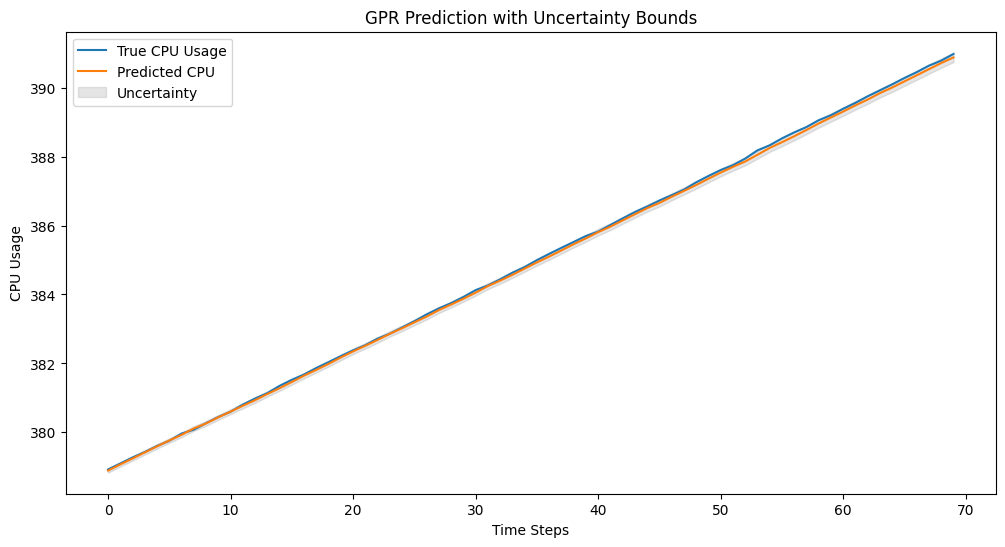

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define input and target
# Define input and target
features = ["hour_of_day", "day_of_week", "cpu_usage_lag_1", "cpu_usage_lag_5", "cpu_roll_mean_10"]
print("🔍 Features used:", features)

# Ensure all features are present
missing_features = [f for f in features if f not in df_pod.columns]
if missing_features:
    print(f"⚠️ Missing features: {missing_features}")
else:
    # Create new DataFrame with only relevant data
    df_features = df_pod[features + ["cpu_usage"]].copy()

    # Drop rows with missing values
    df_features.dropna(inplace=True)

    if df_features.empty:
        print("🚫 No valid data after dropping NaNs. Check feature generation.")
    else:
        X = df_features[features]
        y = df_features["cpu_usage"]

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        # GPR model
        kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)
        gpr.fit(X_train, y_train)
        preds, std = gpr.predict(X_test, return_std=True)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.values, label="True CPU Usage")
        plt.plot(preds, label="Predicted CPU")
        plt.fill_between(range(len(preds)), preds - std, preds + std, alpha=0.2, color='gray', label='Uncertainty')
        plt.legend()
        plt.title("GPR Prediction with Uncertainty Bounds")
        plt.xlabel("Time Steps")
        plt.ylabel("CPU Usage")
        plt.show()

# **Step 5: Model 1 – Gaussian Process Regression (GPR)**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assume df_pod is already loaded from your dataset
# df_pod = pd.read_csv("workload_dataset.csv")

# List of desired features
desired_features = [
    "hour_of_day",
    "day_of_week",
    "cpu_usage_lag_1",
    "cpu_usage_lag_5",
    "cpu_roll_mean_10",
    "req_rate",
    "mem_usage"
]

# Filter available features
available_features = [f for f in desired_features if f in df_pod.columns]
missing_features = [f for f in desired_features if f not in df_pod.columns]

if missing_features:
    print(f"⚠️ Missing features: {missing_features}")

print("\n🧮 Training with features:", available_features)

# Define target
y = df_pod["scale_decision"].copy()

# Select and safely copy feature DataFrame
X = df_pod[available_features].copy()
X.fillna(0, inplace=True)

print("\n🧮 Training with features:", available_features)

⚠️ Missing features: ['req_rate']

🧮 Training with features: ['hour_of_day', 'day_of_week', 'cpu_usage_lag_1', 'cpu_usage_lag_5', 'cpu_roll_mean_10', 'mem_usage']

🧮 Training with features: ['hour_of_day', 'day_of_week', 'cpu_usage_lag_1', 'cpu_usage_lag_5', 'cpu_roll_mean_10', 'mem_usage']


🔍 Fitting GPR...
🔮 Predicting...


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

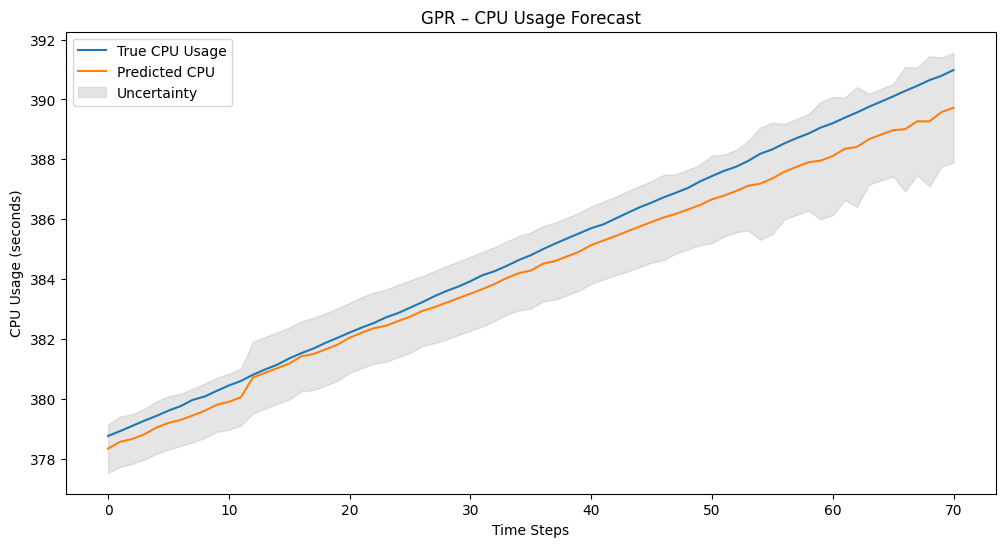

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assume available_features already selected
X = df_pod[available_features].copy()
X.fillna(0, inplace=True)

# Predict numeric CPU usage
y = df_pod["cpu_usage"].copy()

# Train/test split
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert y to numpy array
y_train_arr = y_train.values.ravel()
y_test_arr = y_test.values.ravel()

# Define kernel with bounded parameters
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-2, 1e3)) * \
         RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3))

# Train GPR
gpr = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    alpha=0.1,
    normalize_y=True,
    random_state=42
)

print("🔍 Fitting GPR...")
gpr.fit(X_train_scaled, y_train_arr)

print("🔮 Predicting...")
preds, std = gpr.predict(X_test_scaled, return_std=True)

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_arr, label="True CPU Usage")
plt.plot(preds, label="Predicted CPU")
plt.fill_between(range(len(preds)), preds - std, preds + std, alpha=0.2, color='gray', label='Uncertainty')
plt.legend()
plt.title("GPR – CPU Usage Forecast")
plt.xlabel("Time Steps")
plt.ylabel("CPU Usage (seconds)")
plt

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Map decisions to integers
decision_map = {"scale_down": 0, "no_change": 1, "scale_up": 2}
y = df_pod["scale_decision"].map(decision_map)

# Select and clean features
X = df_pod[available_features].copy()
X.fillna(0, inplace=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Keep as time-series
)

# Train classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

# Print classification report safely
try:
    report = classification_report(
        y_test,
        preds,
        labels=[0, 1, 2],
        target_names=["scale_down", "no_change", "scale_up"],
        zero_division=0
    )
    print(report)
except Exception as e:
    print(f"⚠️ Classification report failed: {e}")

              precision    recall  f1-score   support

  scale_down       0.00      0.00      0.00         0
   no_change       0.00      0.00      0.00         0
    scale_up       1.00      1.00      1.00        71

    accuracy                           1.00        71
   macro avg       0.33      0.33      0.33        71
weighted avg       1.00      1.00      1.00        71



# **Step 6: Model 2 – LSTM Forecasting (Sequence Modeling)**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: nan - val_loss: nan
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: nan - val_loss: nan
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan - val_loss: nan
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - val_loss: nan
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: nan - val_loss: nan
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: nan - val_loss: nan
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - val_loss: nan
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - val_loss: nan
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - val_loss: nan
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: nan - val_loss: nan
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


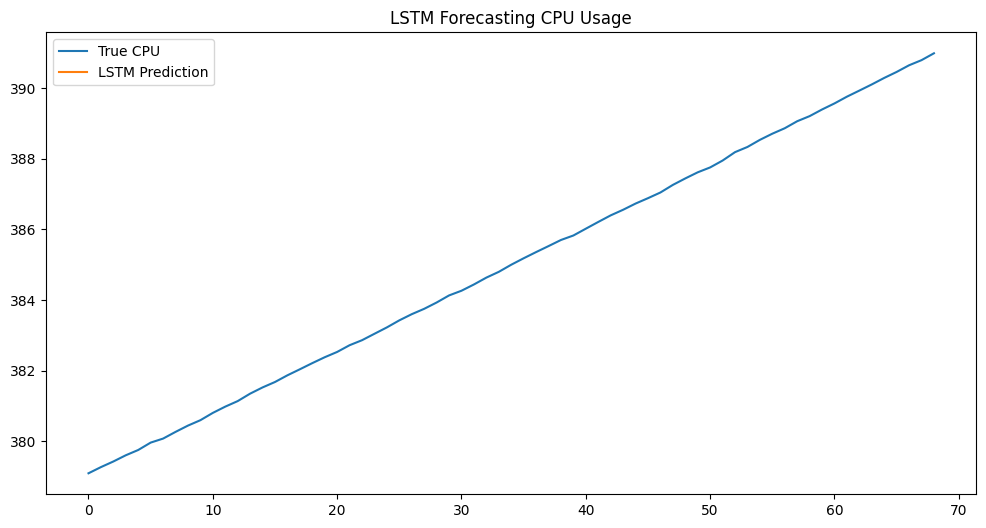

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

SEQ_LENGTH = 10

def create_sequences(data, seq_length):
    windows = []
    labels = []
    for i in range(seq_length, len(data)):
        windows.append(data.iloc[i-seq_length:i][features].values)
        labels.append(data.iloc[i]["cpu_usage"])
    return np.array(windows), np.array(labels)

X_seq, y_seq = create_sequences(df_pod, SEQ_LENGTH)

# Train/test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predict
preds = model.predict(X_test)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="True CPU")
plt.plot(preds, label="LSTM Prediction")
plt.legend()
plt.title("LSTM Forecasting CPU Usage")
plt.show()

# **Step 7: Model 3 – XGBoost Classifier for Scaling Decision**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# List of desired features
desired_features = [
    "hour_of_day",
    "day_of_week",
    "cpu_usage_lag_1",
    "cpu_usage_lag_5",
    "cpu_roll_mean_10",
    "req_rate",
    "mem_usage"
]

# Safely select available features
available_features = [f for f in desired_features if f in df_pod.columns]
missing_features = [f for f in desired_features if f not in df_pod.columns]

if missing_features:
    print(f"⚠️ Missing features: {missing_features}")

print("\n🧮 Training with features:", available_features)

# Define input and target
X = df_pod[available_features].copy()
y = df_pod["scale_decision"].map({"scale_down": 0, "no_change": 1, "scale_up": 2})

# Drop NaNs
valid_mask = y.notnull()
X_valid = X[valid_mask]
y_valid = y[valid_mask].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, shuffle=False
)

# Ensure all classes exist in training data
all_classes = [0, 1, 2]
class_samples = []

for cls in all_classes:
    if cls not in y_train.values:
        # Add a dummy row for the missing class
        dummy_x = X_train.mean().to_dict()
        dummy_y = cls
        class_samples.append((dummy_x, dummy_y))

# Convert dummy samples to DataFrame/Series
if class_samples:
    dummy_X = pd.DataFrame([x for x, y in class_samples])
    dummy_y = pd.Series([y for x, y in class_samples])
    X_train_safe = pd.concat([X_train, dummy_X], ignore_index=True)
    y_train_safe = pd.concat([y_train.reset_index(drop=True), dummy_y.reset_index(drop=True)], ignore_index=True)
else:
    X_train_safe = X_train
    y_train_safe = y_train

print("\n Training XGBoost Classifier...")
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train_safe, y_train_safe)
preds = clf.predict(X_test)

# Print classification report safely
target_names = ["scale_down", "no_change", "scale_up"]
labels = sorted(set(y_valid))  # Actual unique classes in test set

print("\n  Classification Report:")
print(classification_report(
    y_test,
    preds,
    labels=labels,
    target_names=[target_names[i] for i in labels],
    zero_division=0
))

⚠️ Missing features: ['req_rate']

🧮 Training with features: ['hour_of_day', 'day_of_week', 'cpu_usage_lag_1', 'cpu_usage_lag_5', 'cpu_roll_mean_10', 'mem_usage']

🧠 Training XGBoost Classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:26:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Classification Report:
              precision    recall  f1-score   support

   no_change       0.00      0.00      0.00         0
    scale_up       1.00      1.00      1.00        71

    accuracy                           1.00        71
   macro avg       0.50      0.50      0.50        71
weighted avg       1.00      1.00      1.00        71



# **Step 8: Save Versioned Models (Optional)**

In [ ]:
import joblib

# Save GPR model
joblib.dump(gpr, "gpr_model.pkl")

# Save XGBoost model
clf.save_model("xgboost_model.json")